This dataset is a collection of information related to property listings on Airbnb in the city of Seattle, Washington, USA. It includes details about various properties such as price, location, number of rooms, amenities, availability, guest reviews, and more.

Let's start an exploratory data analysis phase with the goal of answering some business-related questions and potentially applying those answers to the real world.

Documento com a explicação de cada uma das informações do dataset
Document with the explanation of each of the dataset information

https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596

### Importing libs

In [173]:
import math
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from re import sub
from decimal import Decimal

listings = pd.read_csv('data/listings.csv')
calendar = pd.read_csv('data/calendar.csv')
reviews = pd.read_csv('data/reviews.csv')

### Auxiliar Functions

In [ ]:
def remover_caracteres_especiais_e_aspas(texto):
    '''
    returns text without special characters and quotes
    input:
            texto: text string 
    output:
            texto_limpo: preprocessed text
    '''

    texto_limpo = re.sub(r'[^\w\s\,]', '', texto)
    return texto_limpo


def calcular_distancia(lat1, lon1, lat2, lon2):
    '''
    returns the distance in kilometers between two coordinates
    input:
            lat1: latitude for first coordenate 
            lon1: longitude for first coordenate 
            lat2: latitude for second coordenate 
            lon2: longitude for second coordenate 
    output:
            distancia: distance in kilometers 
    '''

    raio_da_terra = 6371.0

    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1

    dlat = lat2 - lat1

    # Fórmula de Haversine
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Calcular a distância
    distancia = raio_da_terra * c

    return distancia


def get_distances(x):
    '''
    returns the distance in kilometers from pandas row that contains Latitude and Longitude columns for all touristics_points
    input:
            x: pandas row
    output:
            x: pandas row contains the distance in kilometers for all touristics_points in separate columns
    '''

    for pt in touristics_points:
        lat_pt = pt['Latitude']
        lon_pt = pt['Longitude']
        
        lat_house = x['latitude']
        lon_house = x['longitude']
        
        distancia = calcular_distancia(lat_pt, lon_pt, lat_house, lon_house)
        x[pt['Nome']] = distancia
    
    return x

### EDA - Explaratory Data Analysis

#### Understand the data structure

- What is the size of dataset (number of rows and columns) ?
- What are the data types (for example: numeric, categorical, dates) ?
- Are There any missing values in the data ?

#### The amount of data.

In [2]:
print(f"Number of real estate listing data: {listings.shape[0]}")
print(f"Amount of features about each property: {listings.shape[1]}")
print()
print(f"Number of booking data: {calendar.shape[0]}")
print(f"Amount of features about each booking: {calendar.shape[1]}")
print()
print(f"Number of review data: {reviews.shape[0]}")
print(f"Amount of features about each listing: {reviews.shape[1]}")

Number of real estate listing data: 3818
Amount of features about each property: 92

Number of booking data: 1393570
Amount of features about each booking: 4

Number of review data: 84849
Amount of features about each listing: 6


#### Amount of data type

In total, there are 30 numeric variables and 62 object variables, which can be textual data or any other data structure, such as dates, dictionaries, etc.

In [3]:
listings.dtypes.reset_index().groupby(0).count()

,index
0,
int64,13
float64,17
object,62


#### Visualizing the distribution of values for the numeric variables.

Some possible important numeric columns.

- accommodates
- bathrooms
- bedrooms
- latitude
- longitude
- number_of_reviews
- review_scores_rating
- beds
- square_feet

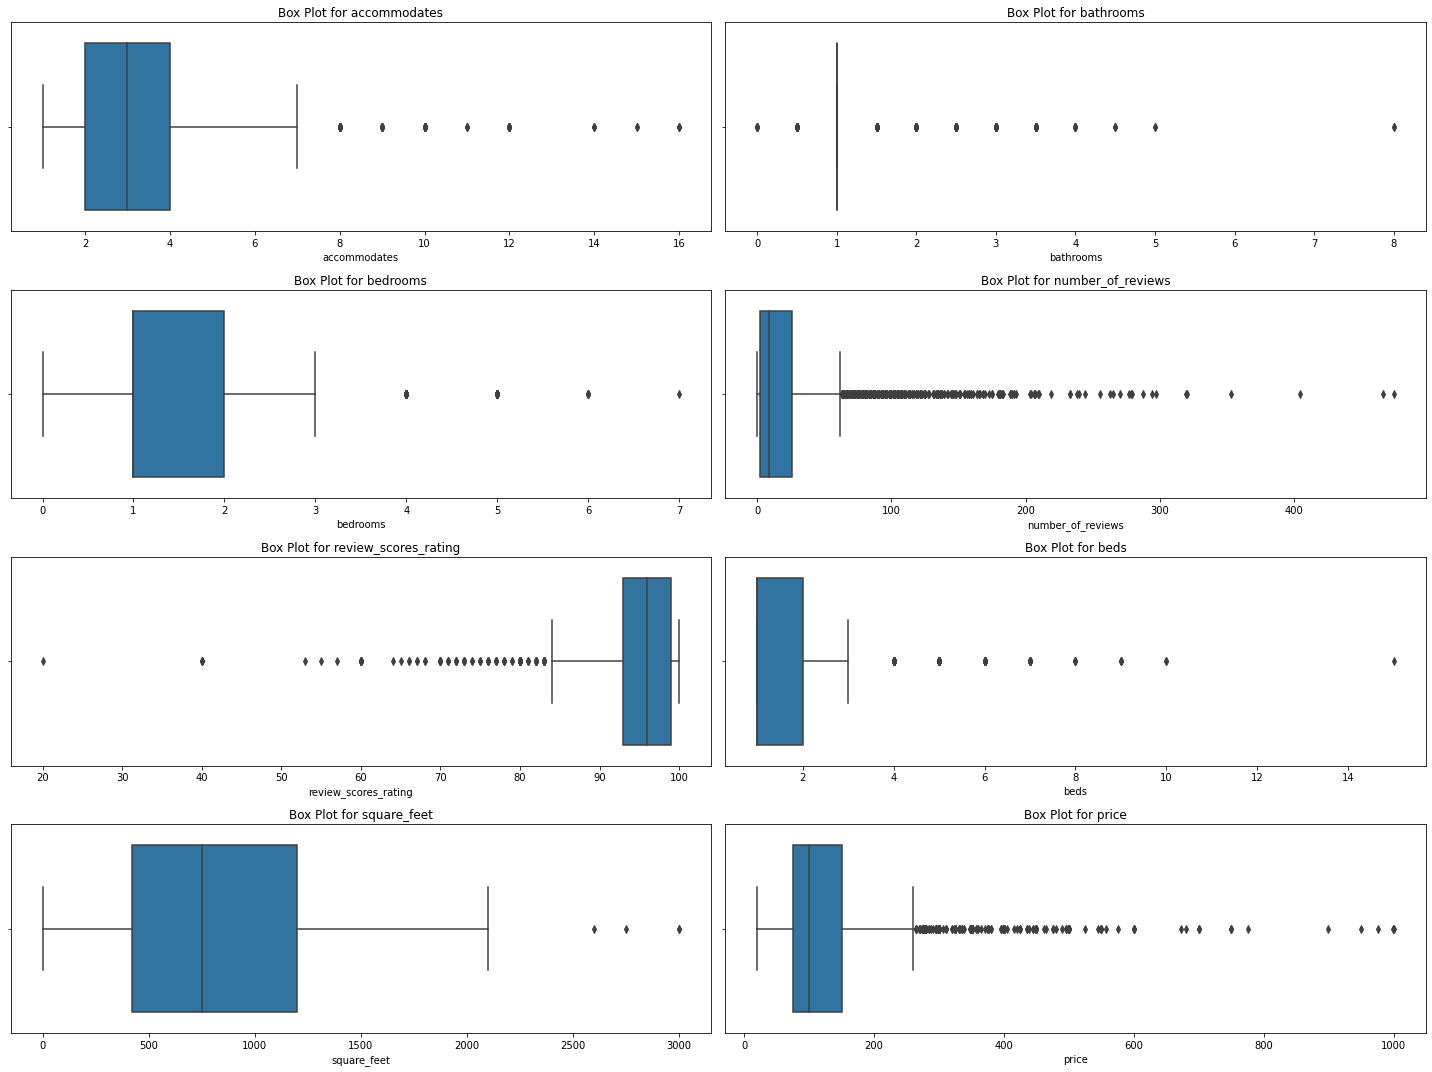

In [5]:
listings['price'] = listings['price'].apply(lambda x: float(Decimal(sub(r'[^\d.]', '', x))))

columns = [
    'accommodates',
    'bathrooms',
    'bedrooms',
    'number_of_reviews',
    'review_scores_rating',
    'beds',
    'square_feet',
    'price'
]

df = listings.select_dtypes(include=['int64', 'float64'])[columns]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))  # 1 linha e 4 colunas de subplots

axes = axes.flatten()

for i, col in enumerate(df.columns):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Box Plot for {col}')

plt.tight_layout()
plt.savefig('boxplot_numeric.png')
plt.show()

#### Distribution of host locations.

Some possible important categorical columns.

- host_location
- host_neighbourhood
- property_type
- amenities
- neighbourhood
- street

Text(0, 0.5, 'Value')

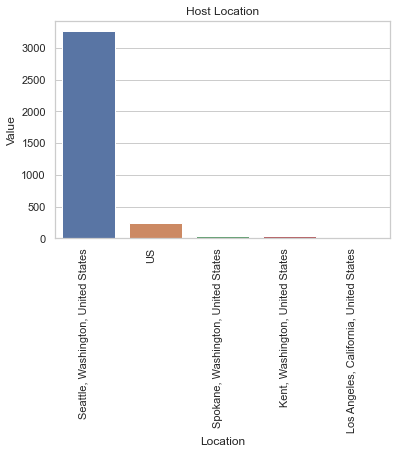

In [6]:
host_location = listings['host_location'].value_counts().reset_index().head(5)

sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=host_location['host_location'], y=host_location['count'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

plt.title("Host Location")
plt.xlabel("Location")
plt.ylabel("Value")

#### Distribution of neighborhoods.

Text(0, 0.5, 'Value')

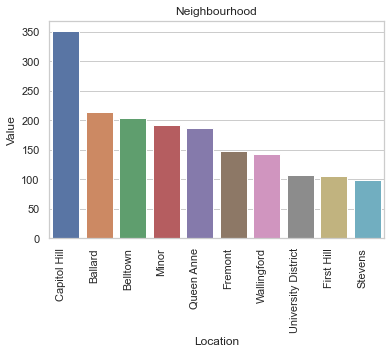

In [7]:
host_location = listings['neighbourhood'].value_counts().reset_index().head(10)

sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=host_location['neighbourhood'], y=host_location['count'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

plt.title("Neighbourhood")
plt.xlabel("Location")
plt.ylabel("Value")

#### Distribution of property types.

Text(0, 0.5, 'Count')

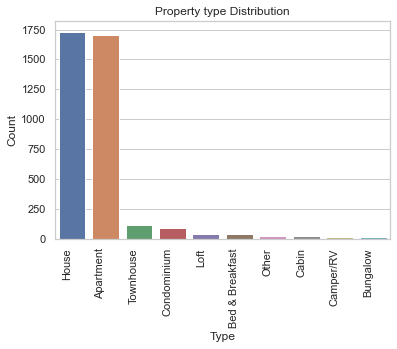

In [8]:
host_location = listings['property_type'].value_counts().reset_index().head(10)

sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=host_location['property_type'], y=host_location['count'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

plt.title("Property type Distribution")
plt.xlabel("Type")
plt.ylabel("Count")

#### Distribution of amenities offered by the rental.

In [9]:
listings['amenities_list'] = listings['amenities'].apply(remover_caracteres_especiais_e_aspas)
dummies = listings['amenities_list'].str.get_dummies(sep=',')

listings = pd.concat([listings, dummies], axis=1)

In [10]:
# TOP 10 Comodidades

listings[dummies.columns].sum().sort_values(ascending=False).head(10)

Wireless Internet    3667
Heating              3627
Kitchen              3423
Smoke Detector       3281
Essentials           3237
Dryer                2997
Washer               2992
Internet             2811
Shampoo              2670
TV                   2574
dtype: int64

Text(0, 0.5, 'Count')

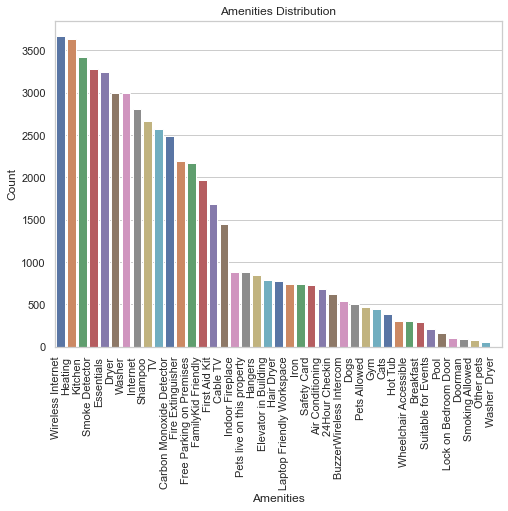

In [11]:
counts = listings[dummies.columns].sum().sort_values(ascending=False).reset_index()

# Criar um gráfico de barras usando o Seaborn
sns.set(style="whitegrid")  # Estilo do gráfico (opcional)

plt.figure(figsize=(8, 6))  # Tamanho da figura (opcional)
ax = sns.barplot(x=counts['index'], y=counts[0], palette="deep")  # Criação do gráfico
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
# Personalização do gráfico
plt.title("Amenities Distribution")
plt.xlabel("Amenities")
plt.ylabel("Count")

#### Quantidade de valores nulos

In [12]:
print("Colunas contendo valores nulos:", sum(listings.isnull().sum() > 0))
percentual = (listings.isnull().sum().sum() / (listings.shape[0] * listings.shape[1])) * 100
print(f"Percentual de valores nulos: {percentual:.2f}%")

Colunas contendo valores nulos: 46
Percentual de valores nulos: 5.83%


In [13]:
(listings.isnull().sum() / len(listings)) * 100

id                       0.0
listing_url              0.0
scrape_id                0.0
last_scraped             0.0
name                     0.0
                        ... 
TV                       0.0
Washer                   0.0
Washer  Dryer            0.0
Wheelchair Accessible    0.0
Wireless Internet        0.0
Length: 134, dtype: float64

Text(0, 0.5, 'Count')

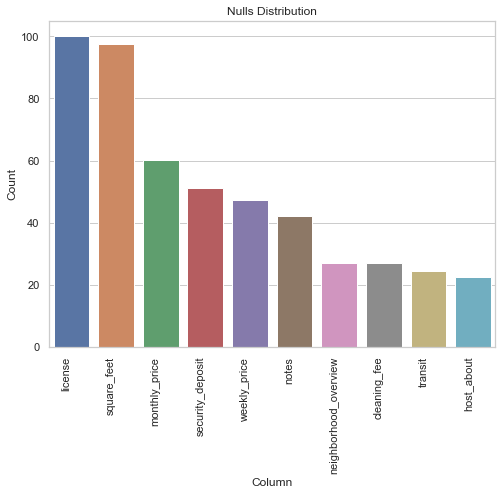

In [14]:
# TOP 10 Colunas com dados faltantes

nulos = round(listings.isnull().mean() * 100, 2).sort_values(ascending=False).reset_index().head(10)

# Criar um gráfico de barras usando o Seaborn
sns.set(style="whitegrid")  # Estilo do gráfico (opcional)

plt.figure(figsize=(8, 6))  # Tamanho da figura (opcional)
ax = sns.barplot(x=nulos['index'], y=nulos[0], palette="deep")  # Criação do gráfico
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
# Personalização do gráfico
plt.title("Nulls Distribution")
plt.xlabel("Column")
plt.ylabel("Count")

### Percepções de Negócios

#### Tratando os dados (Unificando as informações do imóvel a sua reserva)

In [15]:
calendar['price'] = calendar['price'].str.replace('[\$,]', '', regex=True).astype(float)

In [16]:
merged_df = pd.merge(calendar, listings, left_on='listing_id', right_on='id', how='inner')

In [17]:
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['month'] = merged_df['date'].dt.month

**1 - Qual é a sazonalidade e a tendência de preços das propriedades em Seattle?**

Esta pergunta pode ajudar os proprietários de imóveis a ajustar suas estratégias de preços com base em tendências sazonais. Por exemplo, é possível identificar os meses ou épocas do ano em que os preços sobem ou caem, permitindo que os anfitriões otimizem suas tarifas para maximizar o lucro.

In [202]:
media_precos_por_mes = merged_df.groupby('month')['price_x'].mean()
nomes_meses = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
media_precos_por_mes.index = nomes_meses
media_precos_por_mes = media_precos_por_mes.rename_axis('month')
media_precos_por_mes = media_precos_por_mes.reset_index()
media_precos_por_mes

,month,price_x
0,January,122.912176
1,February,124.293927
2,March,128.644488
3,April,135.097005
4,May,139.538183
5,June,147.473137
6,July,152.094150
7,August,150.656594
8,September,143.255949
9,October,137.031939


Text(0, 0.5, 'Value')

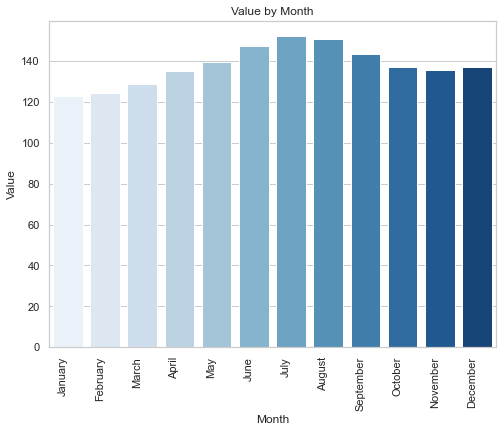

In [203]:
# https://www.seattletimes.com/seattle-news/weather/seattle-specific-seasons-and-the-different-types-of-rain/
sns.set(style="whitegrid") 
plt.figure(figsize=(8, 6)) 

ax = sns.barplot(x=media_precos_por_mes['month'], y=media_precos_por_mes['price_x'], palette='Blues')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

plt.title("Value by Month")
plt.xlabel("Month")
plt.ylabel("Value")

**2 - Quais bairros de Seattle têm os preços mais elevados e por quê?**

Esta pergunta é relevante para investidores imobiliários que desejam identificar áreas de alto potencial de retorno sobre o investimento. Ao entender quais bairros têm preços mais elevados e quais fatores influenciam esses preços (como proximidade a pontos turísticos, comodidades, segurança, etc.), os investidores podem tomar decisões informadas sobre onde investir.

In [20]:
neighborhood_reviews = merged_df[~merged_df['neighborhood_overview'].isnull()]

In [21]:
neighbourhood_mean_price = merged_df.groupby('neighbourhood')['price_x'].mean()

In [32]:
neighbourhood_mean_price.sort_values(ascending=False).head(3)

neighbourhood
Fairmount Park         370.000000
Portage Bay            250.885285
Industrial District    245.875441
Name: price_x, dtype: float64

In [29]:
fairmount_neigh = neighborhood_reviews[neighborhood_reviews['neighbourhood'] == 'Fairmount Park']
fairmount_review = ' '.join(fairmount_neigh['neighborhood_overview'].value_counts().reset_index()['neighborhood_overview'].tolist())

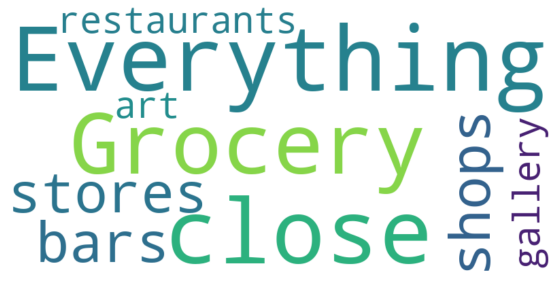

In [30]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fairmount_review)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

O bairro Fairmount Park está localizado em West Seattle, que mencionei anteriormente como um bairro conhecido por suas belas vistas panorâmicas da cidade e pela comunidade à beira-mar. Embora Fairmount Park possa não ser tão amplamente reconhecido quanto alguns dos bairros mais icônicos de Seattle, ele faz parte do charme e da diversidade dessa área de West Seattle.

In [33]:
portage_neigh = neighborhood_reviews[neighborhood_reviews['neighbourhood'] == 'Portage Bay']
portage_review = ' '.join(portage_neigh['neighborhood_overview'].value_counts().reset_index()['neighborhood_overview'].tolist())

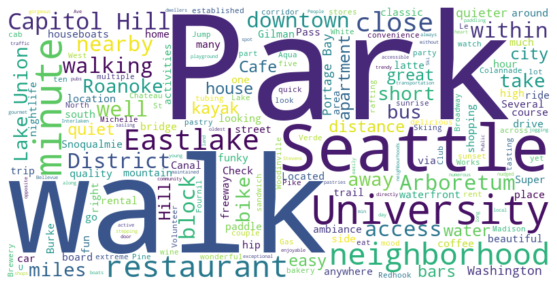

In [34]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(portage_review)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Em resumo, Portage Bay é um bairro tranquilo e cênico de Seattle, conhecido por sua localização à beira d'água, casas flutuantes e proximidade com a Universidade de Washington. É uma área encantadora para se explorar, especialmente se você gosta de ambientes à beira d'água e aprecia a serenidade das áreas residenciais.

In [35]:
industrial_neigh = neighborhood_reviews[neighborhood_reviews['neighbourhood'] == 'Industrial District']
industrial_review = ' '.join(industrial_neigh['neighborhood_overview'].value_counts().reset_index()['neighborhood_overview'].tolist())

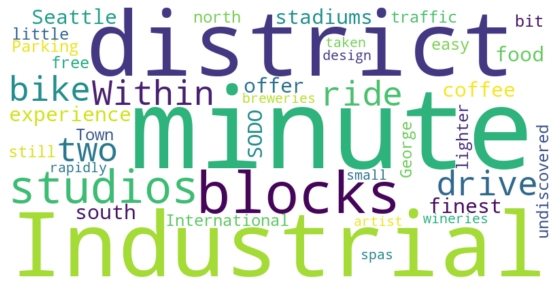

In [36]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(industrial_review)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

O Industrial District, também conhecido como SoDo (South of Downtown), é um bairro de Seattle, Washington, localizado ao sul do centro da cidade. O Industrial District é notável por sua natureza industrial e comercial. É uma área onde você encontrará muitos armazéns, empresas de logística, estabelecimentos de fabricação e distribuição, lojas de suprimentos industriais e empresas relacionadas à indústria. É importante notar que, embora o Industrial District seja um bairro predominantemente industrial, ele está passando por mudanças e desenvolvimento, com alguns espaços sendo adaptados para uso comercial e residencial à medida que a cidade de Seattle continua a crescer e se desenvolver

In [37]:
neighbourhood_mean_price.sort_values(ascending=False).tail(3)

neighbourhood
Riverview        77.346276
Olympic Hills    66.256790
Roxhill          60.000000
Name: price_x, dtype: float64

In [38]:
riverview_neigh = neighborhood_reviews[neighborhood_reviews['neighbourhood'] == 'Riverview']
riverview_review = ' '.join(riverview_neigh['neighborhood_overview'].value_counts().reset_index()['neighborhood_overview'].tolist())

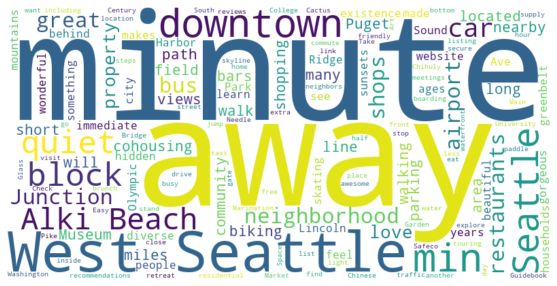

In [39]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(riverview_review)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Riverview bairro menor ou uma área residencial de Seattle que pode não estar entre os bairros mais conhecidos ou amplamente mencionados em fontes públicas.

In [40]:
olympic_neigh = neighborhood_reviews[neighborhood_reviews['neighbourhood'] == 'Olympic Hills']
olympic_review = ' '.join(olympic_neigh['neighborhood_overview'].value_counts().reset_index()['neighborhood_overview'].tolist())

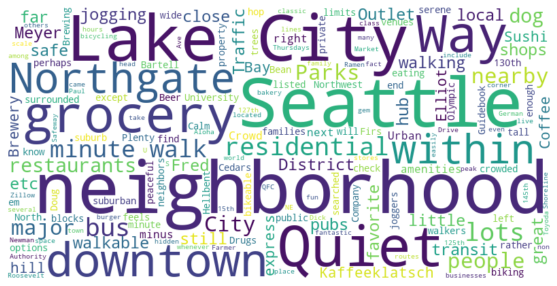

In [41]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(olympic_review)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Olympic Hills Como muitos bairros em Seattle, Olympic Hills oferece um ambiente suburbano tranquilo, enquanto ainda está relativamente próximo ao centro da cidade e às comodidades urbanas. É um local residencial popular para quem procura um ambiente mais tranquilo e familiar em Seattle.

In [42]:
roxhill_neigh = neighborhood_reviews[neighborhood_reviews['neighbourhood'] == 'Roxhill']
roxhill_review = ' '.join(roxhill_neigh['neighborhood_overview'].value_counts().reset_index()['neighborhood_overview'].tolist())

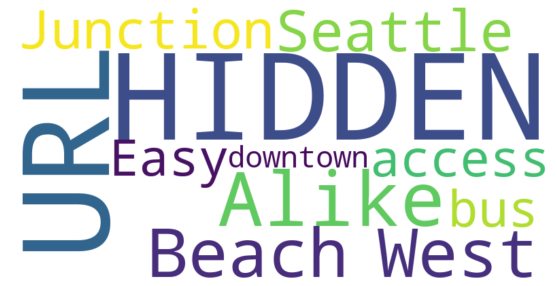

In [43]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(roxhill_review)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Roxhill está situado na parte sudoeste de West Seattle, o que o torna relativamente próximo ao centro de Seattle e a outras partes da cidade. A área é acessível por meio de estradas principais, como a Roxbury Street.

**3 - Qual é a influência da localização e da proximidade a atrações turísticas nos preços das propriedades?**

Esta pergunta é relevante para os proprietários de imóveis que desejam entender como a localização afeta os preços de aluguel. Pode ajudar a determinar se estar perto de atrações populares, transporte público ou áreas comerciais aumenta o valor das propriedades.

In [157]:
#https://visitseattle.org/things-to-do/sightseeing/top-25-attractions/

In [ ]:
- Space Needle
- Pike Place Market
- Seattle Art Museum
- Museum of History
- Pacific Science Center
- Museum Of Flight
- Discovery Park
- Woodland Park
- Museum of Pop Culture
- Fremont Troll
- Argosy Cruises

In [158]:
touristics_points = [
      {
         "Nome":"Space Needle",
         "Latitude":47.62092572973938,
         "Longitude":-122.3481401341854
      },
      {
         "Nome":"Pike Place Market",
         "Latitude":47.60909773432572,
         "Longitude":-122.34058366145146
      },
      {
         "Nome":"Seattle Art Museum",
         "Latitude":47.60759756895055,
         "Longitude":-122.33763803031542
      },
      {
         "Nome":"Museum of History",
         "Latitude":47.62765538483897,
         "Longitude":-122.33616612476729
      },
      {
         "Nome":"Pacific Science Center",
         "Latitude":47.61951285709084,
         "Longitude":-122.35104849305539
      },
      {
         "Nome":"Museum Of Flight",
         "Latitude":47.519353263865526,
         "Longitude":-122.29174429224082
      },
      {
         "Nome":"Discovery Park",
         "Latitude":47.66275971682826,
         "Longitude":-122.40745418035776
      },
      {
         "Nome":"Woodland Park",
         "Latitude":47.66851524684853,
         "Longitude":-122.35036370315643
      },
      {
         "Nome":"Museum of Pop Culture",
         "Latitude":47.62159805184844,
         "Longitude":-122.34838198807611
      },
      {
         "Nome":"Fremont Troll",
         "Latitude":47.65115669127086,
         "Longitude":-122.347187658003
      },
      {
         "Nome":"Argosy Cruises",
         "Latitude":47.60487951257993,
         "Longitude":-122.33946018116443
      }
   ]

In [159]:
nomes = [item['Nome'] for item in touristics_points]

In [178]:
coords = merged_df.groupby('listing_id').agg({'latitude': 'first', 'longitude': 'first'}).reset_index()

In [179]:
coords = coords.apply(get_distances, axis=1)

In [205]:
def count_near_pt(x):
    return x.count()

listings['COUNT_PT_NEAR'] = coords[coords < 5].apply(count_near_pt, axis=1)

count_pt_near = listings[['COUNT_PT_NEAR', 'price']].groupby('COUNT_PT_NEAR').mean().reset_index()

In [206]:
count_pt_near.head()

,COUNT_PT_NEAR,price
0,1,124.568878
1,2,128.876344
2,3,127.593496
3,4,133.910305
4,5,113.958333


Text(0, 0.5, 'Price')

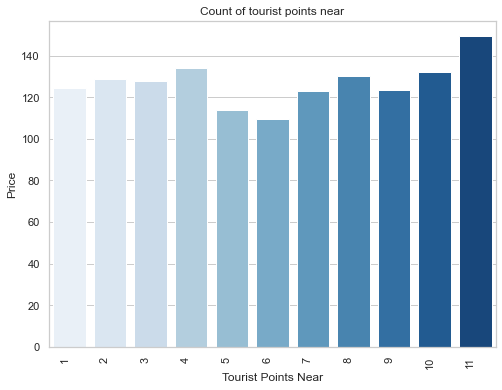

In [208]:
sns.set(style="whitegrid") 
plt.figure(figsize=(8, 6)) 

ax = sns.barplot(x=count_pt_near['COUNT_PT_NEAR'], y=count_pt_near['price'], palette='Blues')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

plt.title("Count of tourist points near")
plt.xlabel("Tourist Points Near")
plt.ylabel("Price")

In [201]:
listings[['COUNT_PT_NEAR', 'price']].corr()

,COUNT_PT_NEAR,price
COUNT_PT_NEAR,1.00000,0.00383
price,0.00383,1.00000


Aparentemente a quantidade/proximidade de pontos turisticos não possui uma relacao bem definida com o preço do aluguel. Isso se dá ao fato de o ponto 5 ter tido uma queda brusca, porem pode se dizer que estar proximo de 10 pontos turisticos tenha alguma influencia no preço. A correlação dela é muito proxima a 0, indicando não ter muita influência na cidade de seattle.

**4 - Como as características da propriedade, como número de quartos, comodidades ou tipo de propriedade, afetam os preços?**

Esta pergunta pode ser útil para anfitriões que desejam melhorar suas listagens. Ao identificar as características que mais influenciam os preços, eles podem fazer ajustes em suas propriedades para aumentar seu apelo e valor de mercado.


Colunas correspondentes a esse tipo de analise 

- accomodates
- bathrooms
- bedrooms
- beds
- bed_type
- room_type
- cleaning_fee
- security_deposit
- square_feet
- amenities

In [51]:
cols_caracteristicas = [
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'bed_type',
    'room_type',
    'cleaning_fee',
    'security_deposit',
    'square_feet',
    'price_x'
]

cols_caracteristicas = cols_caracteristicas + list(dummies.columns)

cols_caracteristicas_obj = merged_df[cols_caracteristicas].select_dtypes(['object'])
cols_caracteristicas_num = merged_df[cols_caracteristicas].select_dtypes(['int', 'float'])

In [52]:
correlation_matrix = cols_caracteristicas_num.corr()['price_x'].drop('price_x')

In [53]:
most_correlated_price = correlation_matrix.sort_values(ascending=False).head(10).reset_index()

Text(0, 0.5, 'Correlation')

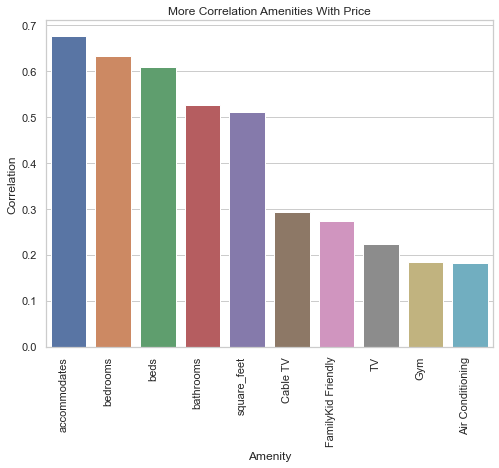

In [54]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=most_correlated_price['index'], y=most_correlated_price['price_x'], palette="deep")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

plt.title("More Correlation Amenities With Price")
plt.xlabel("Amenity")
plt.ylabel("Correlation")

In [55]:
less_correlated_price = correlation_matrix.sort_values(ascending=False).tail(10).reset_index()

Text(0, 0.5, 'Correlation')

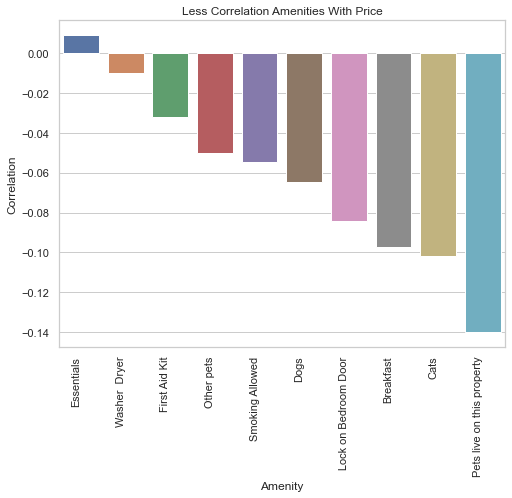

In [56]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=less_correlated_price['index'], y=less_correlated_price['price_x'], palette="deep")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

plt.title("Less Correlation Amenities With Price")
plt.xlabel("Amenity")
plt.ylabel("Correlation")

In [154]:
data = cols_caracteristicas_num.dropna(subset='price_x')

Text(0, 0.5, 'Frequency')

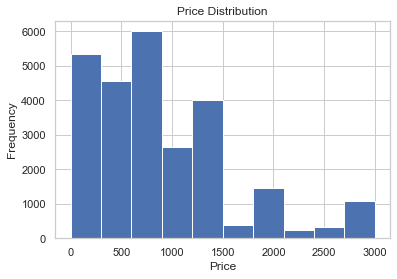

In [156]:
import matplotlib.pyplot as plt

data['square_feet'].hist()
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

In [151]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

data = cols_caracteristicas_num.dropna(subset='price_x')
data['square_feet'] = data['square_feet'].fillna(data['square_feet'].median())
data = data.dropna(subset=['accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet'])
X = data[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet']]
y = data['price_x']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

reg = LinearRegression().fit(X_train, y_train)
preds = reg.predict(X_test)

print('R2:', r2_score(y_test, preds))

C:\Users\sword\AppData\Local\Temp\ipykernel_10476\3361000804.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['square_feet'] = data['square_feet'].fillna(data['square_feet'].median())


Score: 0.5114140487666362

Coef: [2.30325730e+01 3.44814984e+01 2.22691802e+01 1.97495593e-01
 1.02592336e-02], Intercep: -18.476010183951615

R2: 0.5123365099262926
